In [79]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import logsumexp
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

In [3]:
os.chdir('C:/Users/sidew/Desktop/Fasal/assessment/')

In [4]:
"Evaluation helper function"

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [174]:
"Granger Causality test helper function"

maxlag=24
test = 'ssr_ftest'
def grangers_causation_matrix(data, variables, test='ssr_ftest', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [171]:
"Johansen's cointegration test helper function"

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,24)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

### IOT DATA

In [7]:
iot = pd.read_csv('plot2-IoT Sensor Data.csv')

In [8]:
iot_hum = iot[iot['sensor'] == 'HUM']
iot_temp = iot[iot['sensor'] == 'TC']
iot_pres = iot[iot['sensor'] == 'PRES']

Considering timestamp only until the minutes part 

In [9]:
iot_pres['date-hr'] = [i[0:16] for i in iot_pres['datetime']]
iot_hum['date-hr'] = [i[0:16] for i in iot_hum['datetime']]
iot_temp['date-hr'] = [i[0:16] for i in iot_temp['datetime']]

C:\Users\sidew\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sidew\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sidew\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Combining pressure, temperature, and humidity sensor data in a single row for each hour

In [10]:
iot_1 = pd.merge(iot_pres, iot_hum, on = 'date-hr', how = 'inner')
iot_fin = pd.merge(iot_temp, iot_1, on = 'date-hr', how = 'inner')

In [11]:
iot_fin.columns = ['tem','temp','giv_datetime','datetime','pr','pres','giv2','hu','hum','giv3']

In [12]:
iot_fin = iot_fin[['datetime','temp','pres','hum']]
iot_fin['date'] = [i[0:10] for i in iot_fin['datetime']]

<B>AUTOCORRELATION FUNCTION PLOTS (ACF) FOR IOT SENSOR DATA<B>

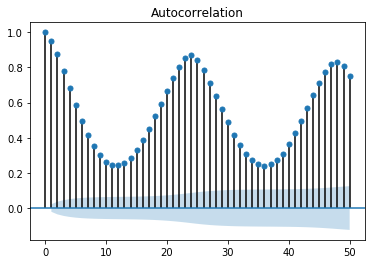

In [13]:
plot_acf(iot_fin['hum'], lags = 50)
pyplot.show()

<B>PARTIAL AUTOCORRELATION FUNCTION PLOTS FOR IOT SENSOR DATA <B>

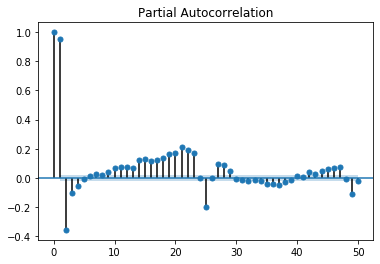

In [14]:
plot_pacf(iot_fin['hum'],lags = 50)
pyplot.show()

### SOURCE 1 AND 2

In [15]:
source1 = pd.read_csv('plot2-Source 1 Weather.csv')
source2 = pd.read_csv('plot2-Source 2 Weather.csv')

In [16]:
source1['date'] = [i[0:10] for i in source1['datetime']]
source2['date'] = [i[0:10] for i in source2['datetime']]

In [17]:
source1_temp = source1[['value','datetime','date']][source1['sensor'] == 'TC']
source2_temp = source2[['value','datetime','date']][source2['sensor'] == 'TC']

source1_pres = source1[['value','datetime','date']][source1['sensor'] == 'PRES']
source2_pres = source2[['value','datetime','date']][source2['sensor'] == 'PRES']

source1_hum = source1[['value','datetime','date']][source1['sensor'] == 'HUM']
source2_hum = source2[['value','datetime','date']][source2['sensor'] == 'HUM']

<B>Reshaping Data in Source-1 and Source-2 Datasets to align data from the same hour<B>

In [18]:
source_1tp = pd.merge(source1_temp, source1_pres, on = 'datetime', how = 'inner')
source_1tp.columns = ['temp','datetime','date','pres','giv1']
source_1 = pd.merge(source_1tp, source1_hum, on = 'datetime', how = 'inner')

source_2tp = pd.merge(source2_temp, source2_pres, on = 'datetime', how = 'inner')
source_2tp.columns = ['temp','datetime','date','pres','giv1']
source_2 = pd.merge(source_2tp, source2_hum, on = 'datetime', how = 'inner')

In [19]:
source_1 = source_1[['datetime','date_x','temp','pres','value']]
source_1.columns = ['datetime','date','temp','pres','hum']

source_2 = source_2[['datetime','date_x','temp','pres','value']]
source_2.columns = ['datetime','date','temp','pres','hum']

<B> Introducing Month, Day, and Hour columns in IOT, SOURCE-1, and SOURCE-2 <B>

In [20]:
source_2['month'] = [int(i[5:7]) for i in source_2['datetime']]
source_1['month'] = [int(i[5:7]) for i in source_1['datetime']]
iot_fin['month'] = [int(i[5:7]) for i in iot_fin['datetime']]

source_2['day'] = [int(i[8:10]) for i in source_2['datetime']]
source_1['day'] = [int(i[8:10]) for i in source_1['datetime']]
iot_fin['day'] = [int(i[8:10]) for i in iot_fin['datetime']]

source_2['hour'] = [int(i[11:13]) for i in source_2['datetime']]
source_1['hour'] = [int(i[11:13]) for i in source_1['datetime']]
iot_fin['hour'] = [int(i[11:13]) for i in iot_fin['datetime']]

In [21]:
for i in range(len(source_2)):
    source_2['datetime'][i] = source_2['datetime'][i][0:16]
for i in range(len(source_1)):
    source_1['datetime'][i] = source_1['datetime'][i][0:16]

C:\Users\sidew\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sidew\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<B>AUTOCORRELATION FUNCTION PLOTS (ACF) FOR SOURCE-2 DATA<B>

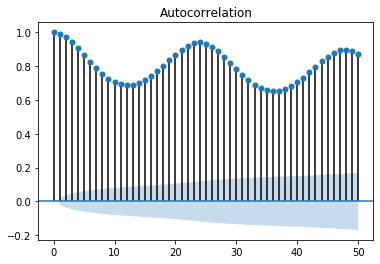

In [22]:
plot_acf(source_2['hum'], lags = 50)
pyplot.show()

<B> PARTIAL AUTOCORRELATION FUNCTION PLOTS FOR SOURCE-2 DATA <B>

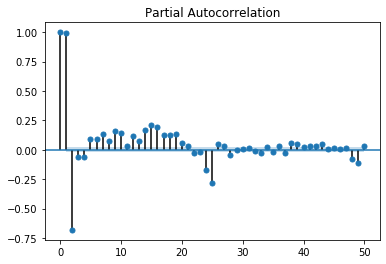

In [23]:
plot_pacf(source_2['hum'], lags = 50)
pyplot.show()

<U> Extra readings found upon comparing source-1 and source-2 <U>

In [24]:
li2 = source_2['date'].unique()
li1 = source_2['date'].unique()
li = []
for i in li1:
    edr = source_1[source_1['date'] == i]
    edt = source_2[source_2['date'] == i]
    if len(edr) != len(edt):
        li.append(i)

### SOURCE-1 CORRECTIONS AND IMPUTATIONS

<B> Frequencey of data collection changes from x:00:00 to x:30:00. Remove the extra record <B>

In [25]:
source_1[source_1['date'] == '2019-09-22']
source_1_disc = source_1[6355:]
source_1_ok = source_1[0:6355]

<B> Manually interpolate the :30 minute data records to estimate values at :00 minutes. <B>

In [26]:
tmp1 = []
prs1 = []
hum1 = []
dt1 = []
dte1 = []
hr1 = []
m1 = []
d1 = []
for i in range(len(source_1_disc)-1):
    tmp1.append((float(source_1_disc['temp'].iloc[i])+float(source_1_disc['temp'].iloc[i+1]))/2)
    prs1.append((float(source_1_disc['pres'].iloc[i])+float(source_1_disc['pres'].iloc[i+1]))/2)
    hum1.append((float(source_1_disc['hum'].iloc[i])+float(source_1_disc['hum'].iloc[i+1]))/2)
    dt1.append(source_1_disc['datetime'].iloc[i+1][0:14]+'00'+source_1_disc['datetime'].iloc[i+1][16:])
    dte1.append(source_1_disc['date'].iloc[i+1])
    hr1.append(source_1_disc['hour'].iloc[i+1])
    m1.append(source_1_disc['month'].iloc[i+1])
    d1.append(source_1_disc['day'].iloc[i+1])

source_1_disc_r = pd.DataFrame({'datetime':dt1,'date':dte1,'temp':tmp1,'pres':prs1,'hum':hum1,'month':m1,'day':d1,'hour':hr1})

In [27]:
source_1 = source_1_ok.append(source_1_disc_r)
source_1 = source_1.reset_index(drop = True)
source_1 = source_1[['datetime','date','temp','pres','hum','month','day','hour']]

<B> Check which combos of month and day have missing entries in Source-1 <B>

In [28]:
df12 = (source_1.groupby(['month','day']).apply(lambda x : 24-len(x)).reset_index(name = 'missing_entries'))
df12_req = df12[df12['missing_entries'] > 0].reset_index(drop = True)

<B> Records are missing in a continuous manner, cannot interpolate on an hourly basis.</B> Hence, values from the previous day at the same time and the next day at the same time were used to impute these missing values 

In [29]:
sd11 = list(range(24))
for i in range(len(df12_req)):
    o,p = df12_req[['month','day']].iloc[i]
    reqs = source_1[(source_1['month'] == o) & (source_1['day'] == p)]
    
    sd12 = [yo for yo in sd11 if yo not in list(reqs['hour'])]
    
    for l in sd12:
        if len(str(l)) == 1:
            hr = str(0)+str(l)
        else:
            hr = str(l)
        
        dt = reqs['datetime'].iloc[0][0:10]+' '+hr+reqs['datetime'].iloc[0][13:]
        dte = reqs['date'].iloc[i]
        tmp = (float(source_1['temp'][(source_1['month'] == o) & (source_1['day'] == p-1) & (source_1['hour'] == int(hr))]) + float(source_1['temp'][(source_1['month'] == o) & (source_1['day'] == p+1) & (source_1['hour'] == int(hr))]))/2
        prs = (float(source_2['pres'][(source_2['month'] == o) & (source_1['day'] == p-1) & (source_1['hour'] == int(hr))]) + float(source_1['pres'][(source_1['month'] == o) & (source_1['day'] == p+1) & (source_1['hour'] == int(hr))]))/2
        hm = (float(source_2['hum'][(source_2['month'] == o) & (source_1['day'] == p-1) & (source_1['hour'] == int(hr))]) + float(source_1['hum'][(source_1['month'] == o) & (source_1['day'] == p+1) & (source_1['hour'] == int(hr))]))/2
        
        cdf = pd.DataFrame({'datetime':dt,
                           'date':dte,
                           'temp':tmp,
                           'pres':prs,
                           'hum':hm,
                           'hour':int(hr),
                           'month':o,
                           'day':p},
                           index = [len(source_1)])
        source_1 = source_1.append(cdf)

source_1 = source_1.sort_values(by = ['datetime'])
source_1 = source_1.reset_index(drop = True)
source_1 = source_1[['datetime','date','temp','pres','hum','month','day','hour']]

C:\Users\sidew\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [30]:
source_1.datetime = pd.to_datetime(source_1.datetime, format = '%Y-%m-%d %H:%M')
source_1 = source_1.set_index('datetime')

source_1_fin = source_1
source_1_fin = source_1_fin[['temp','pres','hum']]

### SOURCE-2 IMPUTATIONS

<B> Check which combos of month and day have missing entries in Source-2 <B>

In [31]:
df2 = (source_2.groupby(['month','day']).apply(lambda x : 24-len(x)).reset_index(name = 'missing_entries'))
df2_req = df2[df2['missing_entries'] > 0].reset_index(drop = True)

<B> Records are missing in a continuous manner, cannot interpolate on an hourly basis.</B> Hence, values from the previous day at the same time and the next day at the same time were used to impute these missing values 

In [32]:
sd = list(range(24))
for i in range(len(df2_req)):
    o,p = df2_req[['month','day']].iloc[i]
    reqs = source_2[(source_2['month'] == o) & (source_2['day'] == p)]
    
    sd2 = [yo for yo in sd if yo not in list(reqs['hour'])]
    
    for l in sd2:
        if len(str(l)) == 1:
            hr = str(0)+str(l)
        else:
            hr = str(l)
        
        dt = reqs['datetime'].iloc[0][0:10]+' '+hr+reqs['datetime'].iloc[0][13:]
        dte = reqs['date'].iloc[i]
        tmp = (float(source_2['temp'][(source_2['month'] == o) & (source_2['day'] == p-1) & (source_2['hour'] == int(hr))]) + float(source_2['temp'][(source_2['month'] == o) & (source_2['day'] == p+1) & (source_2['hour'] == int(hr))]))/2
        prs = (float(source_2['pres'][(source_2['month'] == o) & (source_2['day'] == p-1) & (source_2['hour'] == int(hr))]) + float(source_2['pres'][(source_2['month'] == o) & (source_2['day'] == p+1) & (source_2['hour'] == int(hr))]))/2
        hm = (float(source_2['hum'][(source_2['month'] == o) & (source_2['day'] == p-1) & (source_2['hour'] == int(hr))]) + float(source_2['hum'][(source_2['month'] == o) & (source_2['day'] == p+1) & (source_2['hour'] == int(hr))]))/2
        
        cdf = pd.DataFrame({'datetime':dt,
                           'date':dte,
                           'temp':tmp,
                           'pres':prs,
                           'hum':hm,
                           'hour':int(hr),
                           'month':o,
                           'day':p},
                           index = [len(source_2)])
        source_2 = source_2.append(cdf)

source_2 = source_2.sort_values(by = ['datetime'])
source_2 = source_2.reset_index(drop = True)
source_2 = source_2[['datetime','date','temp','pres','hum','month','day','hour']]

C:\Users\sidew\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


<B> Manually interpolate the data records collected at varying intervals to estimate values at :00 minutes. <B>

In [33]:
tmp2 = []
prs2 = []
hum2 = []
dt2 = []
dte2 = []
hr2 = []
m2 = []
d2 = []
for i in range(len(source_2)-1):
    tmp2.append((float(source_2['temp'].iloc[i])+float(source_2['temp'].iloc[i+1]))/2)
    prs2.append((float(source_2['pres'].iloc[i])+float(source_2['pres'].iloc[i+1]))/2)
    hum2.append((float(source_2['hum'].iloc[i])+float(source_2['hum'].iloc[i+1]))/2)
    dt2.append(source_2['datetime'].iloc[i+1][0:14]+'00'+source_2['datetime'].iloc[i+1][16:])
    dte2.append(source_2['date'].iloc[i+1])
    hr2.append(source_2['hour'].iloc[i+1])
    m2.append(source_2['month'].iloc[i+1])
    d2.append(source_2['day'].iloc[i+1])

source_2_r = pd.DataFrame({'datetime':dt2,'date':dte2,'temp':tmp2,'pres':prs2,'hum':hum2,'month':m2,'day':d2,'hour':hr2})

In [34]:
source_2_r = source_2_r.append(pd.DataFrame({'datetime':source_2['datetime'][0][0:14]+'00','date':source_2['date'][0],
                                             'temp':source_2['temp'][0],'pres':source_2['pres'][0],
                                             'hum':source_2['hum'][0],'hour':source_2['hour'][0],'month':source_2['month'][0],
                                             'day':source_2['day'][0]},index = [8759]))

source_2_r = source_2_r.sort_values(by = ['datetime'])
source_2_r = source_2_r.reset_index(drop = True)
source_2_r = source_2_r[['datetime','date','temp','pres','hum','month','day','hour']]

C:\Users\sidew\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [35]:
source_2_r.datetime = pd.to_datetime(source_2_r.datetime, format = '%Y-%m-%d %H:%M')
source_2_r = source_2_r.set_index('datetime')

source_2_fin = source_2_r
source_2_fin = source_2_fin[['temp','pres','hum']]

### Missing observations in IOT data

In [36]:
li3 = iot_fin['date'].unique()
li2 = source_2['date'].unique()
lit = []
for i in li1:
    edr = source_2[source_2['date'] == i]
    edt = iot_fin[iot_fin['date'] == i]
    if len(edr) != len(edt):
        lit.append(i)

### IOT DATA - CORRECTIONS AND IMPUTATIONS

In [37]:
iot_exper = iot_fin

<B> determining which observations are missing <B>

In [38]:
df2_iot = (iot_fin.groupby(['month','day']).apply(lambda x : 24-len(x)).reset_index(name = 'missing_entries'))

In [39]:
df2_iot_req = df2_iot[df2_iot['missing_entries']>0]
df2_iot_req = df2_iot_req.reset_index(drop = True)

<B> Data is missing irregularly, cannot interpolate manually like we did previously </B>. Forward fill and backward fill would be too naive. For now, we create blank records for the missing observations to impute later

In [40]:
sd = list(range(24))
for i in range(len(df2_iot_req)):
    o,p = df2_iot_req[['month','day']].iloc[i]
    reqs = iot_exper[(iot_exper['month'] == o) & (iot_exper['day'] == p)]
    
    sd2 = [yo for yo in sd if yo not in list(reqs['hour'])]
    
    for l in sd2:
        if len(str(l)) == 1:
            hr = str(0)+str(l)
        else:
            hr = str(l)
        
        dt = reqs['datetime'].iloc[0][0:10]+' '+hr+reqs['datetime'].iloc[0][13:]
        dte = dt[0:10]
        tmp = ''
        prs = ''
        hm = ''
        
        cdf = pd.DataFrame({'datetime':dt,
                           'date':dte,
                           'temp':tmp,
                           'pres':prs,
                           'hum':hm,
                           'hour':int(hr),
                           'month':o,
                           'day':p},
                           index = [len(iot_exper)])
        iot_exper = iot_exper.append(cdf)

iot_exper = iot_exper.sort_values(by = ['datetime'])
iot_exper = iot_exper.reset_index(drop = True)
iot_exper = iot_exper[['datetime','date','temp','pres','hum','month','day','hour']]

C:\Users\sidew\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


<B> A specific day has multiple entries in the same hour but has missing records for quite a few other hours - blank records introduced, extra entries removed

In [41]:
iot_experiment = iot_exper[0:8046].append(iot_exper[8056:])

In [42]:
df3_iot = (iot_experiment.groupby(['month','day']).apply(lambda x : 24-len(x)).reset_index(name = 'missing_entries'))
df3_iot_req = df3_iot[df3_iot['missing_entries']>0]

In [43]:
sd = list(range(24))
o = 12
p = 2
reqs = iot_experiment[(iot_experiment['month'] == o) & (iot_experiment['day'] == p)]
    
sd2 = [yo for yo in sd if yo not in list(reqs['hour'])]

for l in sd2:
    if len(str(l)) == 1:
        hr = str(0)+str(l)
    else:
        hr = str(l)

    dt = reqs['datetime'].iloc[0][0:10]+' '+hr+reqs['datetime'].iloc[0][13:]
    dte = dt[0:10]
    tmp = ''
    prs = ''
    hm = ''

    cdf = pd.DataFrame({'datetime':dt,
                       'date':dte,
                       'temp':tmp,
                       'pres':prs,
                       'hum':hm,
                       'hour':int(hr),
                       'month':o,
                       'day':p},
                       index = [len(iot_experiment)])
    iot_experiment = iot_experiment.append(cdf)

iot_experiment = iot_experiment.sort_values(by = ['datetime'])
iot_experiment = iot_experiment.reset_index(drop = True)
iot_experiment = iot_experiment[['datetime','date','temp','pres','hum','month','day','hour']]

C:\Users\sidew\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


<B> empty spaces introduced due to blank records - changed to na <B>

In [44]:
iot_experiment1 = iot_experiment.replace(r'^\s*$', np.nan, regex=True)

<B> those records which can be imputed manually through previous methods are filled <B>

In [45]:
tmp3 = []
prs3 = []
hum3 = []
dt3 = []
dte3 = []
hr3 = []
m3 = []
d3 = []
for i in range(len(iot_experiment1)-1):
    tmp3.append((float(iot_experiment1['temp'].iloc[i])+float(iot_experiment1['temp'].iloc[i+1]))/2)
    prs3.append((float(iot_experiment1['pres'].iloc[i])+float(iot_experiment1['pres'].iloc[i+1]))/2)
    hum3.append((float(iot_experiment1['hum'].iloc[i])+float(iot_experiment1['hum'].iloc[i+1]))/2)
    dt3.append(iot_experiment1['datetime'].iloc[i+1][0:14]+'00'+iot_experiment1['datetime'].iloc[i+1][16:])
    dte3.append(iot_experiment1['date'].iloc[i+1])
    hr3.append(iot_experiment1['hour'].iloc[i+1])
    m3.append(iot_experiment1['month'].iloc[i+1])
    d3.append(iot_experiment1['day'].iloc[i+1])

iot_experiment1_r = pd.DataFrame({'datetime':dt3,'date':dte3,'temp':tmp3,'pres':prs3,'hum':hum3,'month':m3,'day':d3,'hour':hr3})

In [46]:
iot_experiment1_r = iot_experiment1_r.append(pd.DataFrame({'datetime':iot_experiment1['datetime'][0][0:14]+'00','date':iot_experiment1['date'][0],
                                             'temp':iot_experiment1['temp'][0],'pres':iot_experiment1['pres'][0],
                                             'hum':iot_experiment1['hum'][0],'hour':iot_experiment1['hour'][0],'month':iot_experiment1['month'][0],
                                             'day':iot_experiment1['day'][0]},index = [8759]))

iot_experiment1_r = iot_experiment1_r.sort_values(by = ['datetime'])
iot_experiment1_r = iot_experiment1_r.reset_index(drop = True)
iot_experiment1_r = iot_experiment1_r[['datetime','date','temp','pres','hum','month','day','hour']]

C:\Users\sidew\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


<B> The rest are filled in using a built in cubic interpolation. </B> Method = 'Time' won't work for hourly resolution

### INTERPOLATION - METHOD : CUBIC

In [47]:
iot_experiment1_r.datetime = pd.to_datetime(iot_experiment1_r.datetime, format = '%Y-%m-%d %H:%M')
iot_experiment1_r = iot_experiment1_r.set_index('datetime')

iot_experiment1_r['temp'].interpolate(method='cubic', inplace = True)
iot_experiment1_r['pres'].interpolate(method='cubic', inplace = True)
iot_experiment1_r['hum'].interpolate(method='cubic', inplace = True)

In [48]:
for i in range(len(iot_experiment1_r)):
    if iot_experiment1_r['hum'][i] > 100:
        iot_experiment1_r['hum'][i] = 100

C:\Users\sidew\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
iot_final = iot_experiment1_r[['temp','pres','hum']]

### Decomposing the time series

<B> Clear non-stationarity in the plots - series need to be stationarized. Seasonality is difficult to decipher, further testing required <B>

### Temperature

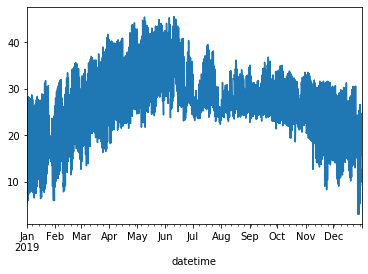

In [50]:
iot_final['temp'].plot()

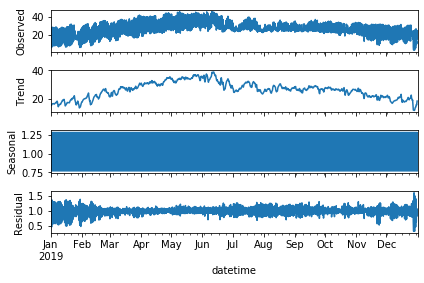

In [51]:
seasonal_decompose(iot_final['temp'], model = 'multiplicative').plot()
pyplot.show()

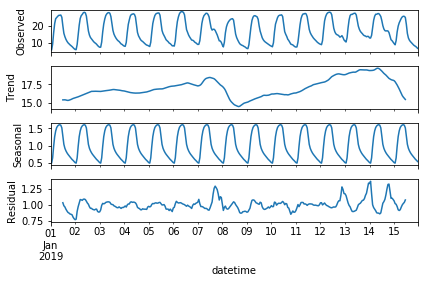

In [52]:
seasonal_decompose(iot_final['temp'][0:360], model = 'multiplicative').plot()
pyplot.show()

### Pressure

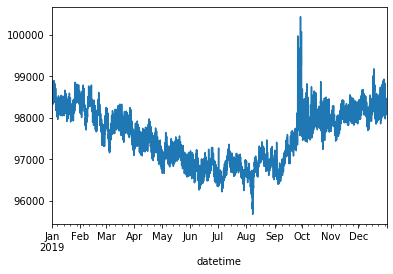

In [53]:
iot_final['pres'].plot()

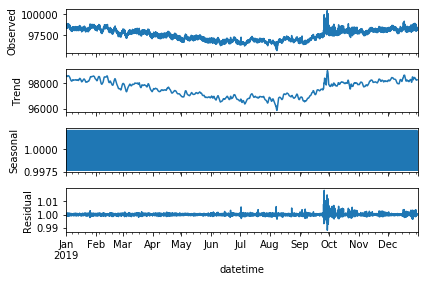

In [54]:
seasonal_decompose(iot_final['pres'], model = 'multiplicative').plot()
pyplot.show()

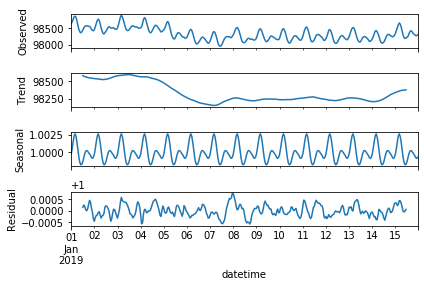

In [55]:
seasonal_decompose(iot_final['pres'][0:360], model = 'multiplicative').plot()
pyplot.show()

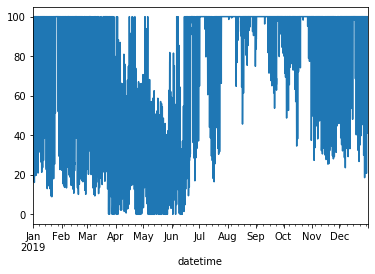

In [56]:
iot_final['hum'].plot()

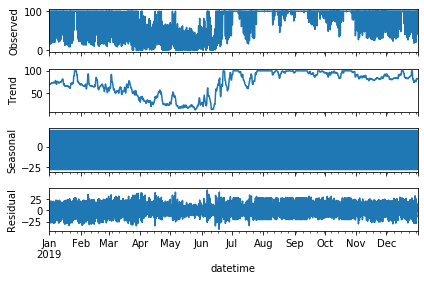

In [57]:
seasonal_decompose(iot_final['hum'], model = 'additive').plot()
pyplot.show()

<B> Creating a Master Dataframe

In [58]:
req_df = pd.merge(iot_experiment1_r, source_2_r, on = source_2_r.index, how = 'inner')

In [59]:
req_df = req_df[['key_0','temp_x','pres_x','hum_x','temp_y','pres_y','hum_y','date_x','month_x','day_x','hour_x']]
req_df.columns = ['datetime','iot_temp','iot_pres','iot_hum','src2_temp','src2_pres','src2_hum','date','month','day','hour']
req_df = req_df.set_index('datetime')

In [60]:
req_df = pd.merge(req_df,source_1, on = source_1.index, how = 'inner')

In [61]:
req_df = req_df[['key_0','iot_temp','iot_pres','iot_hum','temp','pres','hum','src2_temp','src2_pres','src2_hum','date_x','month_x','day_x','hour_x']]
req_df.columns = ['datetime','iot_temp','iot_pres','iot_hum','src1_temp','src1_pres','src1_hum','src2_temp','src2_pres','src2_hum','date','month','day','hour']
req_df = req_df.set_index('datetime')

<B> Creating a Scaled version for analyses <B>

In [62]:
scaler = StandardScaler()
req_df_scaled = pd.DataFrame(scaler.fit_transform(req_df[['iot_temp','iot_pres','iot_hum','src1_temp','src1_pres','src1_hum','src2_temp','src2_pres','src2_hum']]), columns = ['iot_temp','iot_pres','iot_hum','src1_temp','src1_pres','src1_hum','src2_temp','src2_pres','src2_hum'])

In [63]:
req_df_scaled.index = req_df.index
req_df_scaled['date'] = req_df['date']
req_df_scaled['month'] = req_df['month']
req_df_scaled['day'] = req_df['day']
req_df_scaled['hour'] = req_df['hour']
req_df_scaled['datetime'] = req_df.index

In [64]:
req_df_scaled.to_csv('req_df.csv',index = False)

<B> Verifying non stationarity with Augmented Dickey FullerTest and KPSS Test

In [65]:
req_dff = req_df[['iot_temp','iot_pres','iot_hum','src1_temp','src1_pres','src1_hum','src2_temp','src2_pres','src2_hum']]

In [66]:
def stationarity(df):
    for col in df.columns:
        if col != 'datetime':
            ap = adfuller(df[col])[1]
            kp = kpss(df[col])[1]
            if ap < 0.05:
                adf_res = 'passed at 95%C'
            else:
                adf_res = 'failed at 95%C'
            if kp > 0.05:
                kp_res = 'passed at 95%C'
            else:
                kp_res = 'failed at 95%C'
            print(col, "ADF test: ",adf_res,'\n',col, "KPSS test: ", kp_res, '\n','\n')

### Non stationarity confirmed

In [ ]:
stationarity(req_dff)

### First Differencing to rid the series of non-stationarity

In [112]:
df_diff =pd.DataFrame()
for col in req_dff.columns:
    if col != 'datetime':
        df_diff[col+'_d'] = (req_dff[col]).diff()
# df_diff = df_diff.replace([np.inf, -np.inf], np.nan)
df_diff = df_diff.dropna()

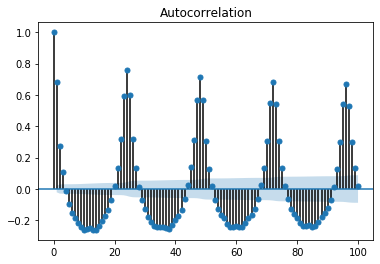

In [113]:
plot_acf(df_diff['iot_hum_d'], lags = 100)
pyplot.show()

In [114]:
for ij in df_diff.columns:
    df_diff[ij] = df_diff[ij].diff(24)
df_diff = df_diff.dropna()

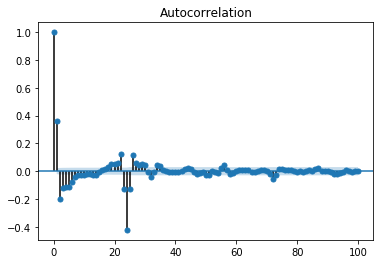

In [115]:
plot_acf(df_diff['iot_hum_d'], lags = 100)
pyplot.show()

### Stationarity confirmed

In [ ]:
stationarity(df_diff)

### Confirming if Stationarity has been ridden of. Logarithmic differencing was tried but the differences of many values tended to 0. Applying a log function on top of this created many undefined values in the data

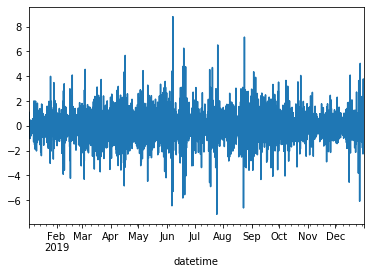

In [116]:
df_diff['iot_temp_d'].plot()

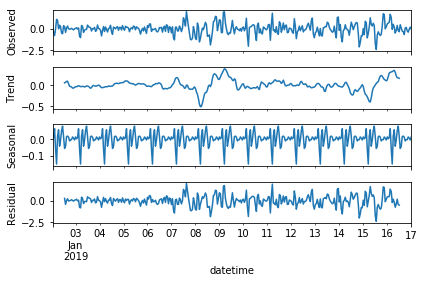

In [117]:
seasonal_decompose(df_diff['iot_temp_d'][0:360], model = 'additive').plot()
pyplot.show()

<B> Granger's Causation Test used to check if source 2 variables are really exogenous </B> The test results indicate that source 2 variables <B> are Granger caused by IOT variables, hence making a case for them not being exogenous </B>

In [175]:
grangers_causation_matrix(df_diff[['iot_temp_d','iot_pres_d','iot_hum_d','src2_temp_d','src2_pres_d','src2_hum_d']], variables = df_diff.columns[[0,1,2,6,7,8]])

C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covar

,iot_temp_d_x,iot_pres_d_x,iot_hum_d_x,src2_temp_d_x,src2_pres_d_x,src2_hum_d_x
iot_temp_d_y,1.0000,0.0000,0.0000,0.0,0.0016,0.0166
iot_pres_d_y,0.0000,1.0000,0.1060,0.0,0.0000,0.0021
iot_hum_d_y,0.0000,0.0993,1.0000,0.0,0.0752,0.0000
src2_temp_d_y,0.0000,0.0035,0.0000,1.0,0.0000,0.0000
src2_pres_d_y,0.0007,0.0000,0.0039,0.0,1.0000,0.0001
src2_hum_d_y,0.0000,0.0000,0.0003,0.0,0.0001,1.0000


In [176]:
grangers_causation_matrix(df_diff[['iot_temp_d','iot_pres_d','iot_hum_d','src1_temp_d','src1_pres_d','src1_hum_d']], variables = df_diff.columns[[0,1,2,3,4,5]])

C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covaria

C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\sidew\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: cov

,iot_temp_d_x,iot_pres_d_x,iot_hum_d_x,src1_temp_d_x,src1_pres_d_x,src1_hum_d_x
iot_temp_d_y,1.0000,0.0000,0.000,0.0000,0.0452,0.0000
iot_pres_d_y,0.0000,1.0000,0.106,0.0537,0.0000,0.0033
iot_hum_d_y,0.0000,0.0993,1.000,0.0000,0.0000,0.0000
src1_temp_d_y,0.0000,0.0244,0.000,1.0000,0.0000,0.0000
src1_pres_d_y,0.0001,0.0000,0.000,0.0000,0.9949,0.0000
src1_hum_d_y,0.0000,0.0178,0.000,0.0968,0.0379,1.0000


<B> Johansen's cointegration test to check if source 2 variables are affected by lagged versions of IOT variables and vice versa. positive outcome is noticed, further strengthening the case for source 1 and 2 not being exogenous to IOT </B>

In [172]:
cointegration_test(req_dff[['iot_temp','iot_pres','iot_hum','src1_temp','src1_pres','src1_hum','src2_temp','src2_pres','src2_hum']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
iot_temp ::  802.17    > 179.5199  =>   True
iot_pres ::  606.18    > 143.6691  =>   True
iot_hum ::  433.26    > 111.7797  =>   True
src1_temp ::  282.64    > 83.9383   =>   True
src1_pres ::  171.59    > 60.0627   =>   True
src1_hum ::  66.86     > 40.1749   =>   True
src2_temp ::  18.07     > 24.2761   =>   False
src2_pres ::  5.44      > 12.3212   =>   False
src2_hum ::  0.0       > 4.1296    =>   False


In [169]:
ts.coint(req_dff['iot_pres'],req_dff['src1_hum'], maxlag = 24)

(-2.904069484414997,
 0.13480420678885224,
 array([-3.8976908 , -3.33682767, -3.04493425]))

In [ ]:
ts.coint()

### Split into train and test <B>

In [ ]:
df_train, df_test = df_diff.iloc[0:-120], df_diff.iloc[-120:]

In [ ]:
df_train_endog = df_train[['iot_temp_d','iot_pres_d','iot_hum_d']]
df_train_exog1 = df_train[['src1_temp_d','src1_pres_d','src1_hum_d']]
df_train_exog2 = df_train[['src2_temp_d','src2_pres_d','src2_hum_d']]


df_test_endog = df_test[['iot_temp_d','iot_pres_d','iot_hum_d']]
df_test_exog1 = df_test[['src1_temp_d','src1_pres_d','src1_hum_d']]
df_test_exog2 = df_test[['src2_temp_d','src2_pres_d','src2_hum_d']]

In [ ]:
df_train_1 = df_train[['iot_temp_d','iot_pres_d','iot_hum_d','src1_temp_d','src1_pres_d','src1_hum_d']]
df_train_2 = df_train[['iot_temp_d','iot_pres_d','iot_hum_d','src2_temp_d','src2_pres_d','src2_hum_d']]

df_test_1 = df_test[['iot_temp_d','iot_pres_d','iot_hum_d','src1_temp_d','src1_pres_d','src1_hum_d']]
df_test_2 = df_test[['iot_temp_d','iot_pres_d','iot_hum_d','src2_temp_d','src2_pres_d','src2_hum_d']]

 ## VARMAX selected since this is a multivariate analysis, and sources are to be used as exogenous variables 

### TAKES TOO LONG TO RUN - ALSO, SRC1 AND SRC2 DATA APPEAR ENDOGENOUS, NOT EXOGENOUS

In [ ]:
# for i in range(5):
#     i+=1
#     model = VARMAX(df_train_endog, order = (i,0), exog = df_train_exog2)
#     result = model.fit(maxiter = 1000, disp = False)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

### ALSO TAKING TOO LONG TO RUN - DIFFERENCE - REMOVED THE EXOGENOUS VARIABLE SPECIFICATION AND PASSED THE EXOG VARIABLES AS ENDOGENOUS

In [ ]:
# for i in range(5):
#     i+=1
#     model = VARMAX(df_train_2, order = (i,0), trend = 'c')
#     result = model.fit(maxiter = 1000, disp = False)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

### TRYING VAR INSTEAD OF VARMAX WITH IOT AND SOURCE 2 DATA BEING CONSIDERED AS ENDOGENOUS - REASONS ABOVE

In [ ]:
model = VAR(df_train_2)

In [ ]:
x = model.select_order(maxlags=12)
x.summary()

### ORDER SELECTED BASED ON DROP in AIC - 7. CORRELATION MATRIX OBTAINED

In [ ]:
model_fitted = model.fit(7)
model_fitted.summary()

### CHECKING FOR CORRELATION IN RESIDUALS - NOTHING SIGNIFICANT (DURBIN WATSON STATISTIC CENTRED AROUND 2) - GOOD MODEL

### This indicates that the model has captured the time series efficiently and the errors are white noise for most part

In [ ]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_train_2.columns, out):
    print((col), ':', round(val, 2))

In [ ]:
forecast_input = df_train_2.values[-7:]

In [ ]:
fc = model_fitted.forecast(y=forecast_input, steps=120)
df_forecast = pd.DataFrame(fc, index = df_diff.index[-120:], columns=df_train_2.columns)

Putting together the first record of the series (missing due to differencing), the records until test set, and the predictions, to <B> obtain a preliminary df which can be cumulatively added up to undo the differencing 

In [ ]:
revert = req_dff.reset_index(drop = False).iloc[0]
revert1 = pd.DataFrame({'iot_temp_d':revert[1],'iot_pres_d':revert[2],'iot_hum_d':revert[3],'src2_temp_d':revert[-3],'src2_pres_d':revert[-2],'src2_hum_d':revert[-1]},index = [0])

In [ ]:
revert1['datetime'] = '2019-01-01 00:00:00'
revert1 = revert1.set_index('datetime')
missing_part = df_train_2[df_train_2.columns][:df_test_2.index[0]]

In [ ]:
rebuilt = revert1.append(missing_part).append(df_forecast)
rebuilt = rebuilt.cumsum()

<B><U> Predictions for Test

In [ ]:
predicted = rebuilt.loc[df_test_2.index[0]:]

<B><U>Actual Test Values

In [ ]:
actual = revert1.append(missing_part).append(df_test_2)
actual = actual.cumsum()

In [ ]:
actual = actual.loc[df_test_2.index[0]:]

### FOR SOURCE-1 AND IOT DATA (DF_TRAIN_1 AND DF_TEST_1)

In [ ]:
model1 = VAR(df_train_1)

In [ ]:
x = model1.select_order(maxlags=12)
x.summary()

### ORDER SELECTED BASED ON DROP in AIC - 6. CORRELATION MATRIX OBTAINED

In [ ]:
model1_fitted = model1.fit(6)
model1_fitted.summary()

### CHECKING FOR CORRELATION IN RESIDUALS - NOTHING SIGNIFICANT (CENTRED AROUND 2) - GOOD MODEL

### This indicates that the model has captured the time series efficiently and the errors are white noise for most part

In [ ]:
out1 = durbin_watson(model1_fitted.resid)

for col, val in zip(df_train_1.columns, out):
    print((col), ':', round(val, 2))

<B><U>Predicting for the test set

In [ ]:
forecast_input1 = df_train_1.values[-6:]

In [ ]:
fc1 = model1_fitted.forecast(y=forecast_input1, steps=120)
df_forecast1 = pd.DataFrame(fc1, index = df_diff.index[-120:], columns=df_train_1.columns)

Putting together the first record of the series (missing due to differencing), the records until test set, and the predictions, to <B> obtain a preliminary df which can be cumulatively added up to undo the differencing 

In [ ]:
revert1 = req_dff.reset_index(drop = False).iloc[0]
revert11 = pd.DataFrame({'iot_temp_d':revert[1],'iot_pres_d':revert[2],'iot_hum_d':revert[3],'src1_temp_d':revert[-3],'src1_pres_d':revert[-2],'src1_hum_d':revert[-1]},index = [0])

In [ ]:
revert11['datetime'] = '2019-01-01 00:00:00'
revert11 = revert11.set_index('datetime')
missing_part1 = df_train_1[df_train_1.columns][:df_test_1.index[0]]

In [ ]:
rebuilt1 = revert11.append(missing_part1).append(df_forecast1)
rebuilt1 = rebuilt1.cumsum()

<B><U> restored predicted values

In [ ]:
predicted1 = rebuilt1.loc[df_test_1.index[0]:]

<B><U> Actual test values

In [ ]:
actual1 = revert11.append(missing_part1).append(df_test_1)
actual1 = actual1.cumsum()

In [ ]:
actual1 = actual1.loc[df_test_1.index[0]:]

## EVALUATION FOR SOURCE2-IOT

In [ ]:
print('Forecast Accuracy of: iot_temp')
accuracy_prod = forecast_accuracy(predicted['iot_temp_d'].values, actual['iot_temp_d'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

In [ ]:
print('Forecast Accuracy of: iot_pres')
accuracy_prod = forecast_accuracy(predicted['iot_pres_d'].values, actual['iot_pres_d'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

In [ ]:
print('Forecast Accuracy of: iot_hum')
accuracy_prod = forecast_accuracy(predicted['iot_hum_d'].values, actual['iot_hum_d'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_req[['iot_temp_d','iot_pres_d','iot_hum_d']].corr(), fignum=f.number)
plt.xticks(range(3), ['iot_temp_d','iot_pres_d','iot_hum_d'], fontsize=14)
plt.yticks(range(3), ['iot_temp_d','iot_pres_d','iot_hum_d'], fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## FINAL PREDICTIONS

In [ ]:
df_req = df_diff[['iot_temp_d','iot_pres_d','iot_hum_d','src2_temp_d','src2_pres_d','src2_hum_d']]

In [ ]:
model_fin = VAR(df_req)

In [ ]:
model_fin_fitted = model_fin.fit(7)

In [ ]:
forecast_input_req = df_req.values[-7:]
fc_req = model_fin_fitted.forecast(y=forecast_input_req, steps=120)
df_forecast_req = pd.DataFrame(fc_req, columns=df_req.columns)

In [ ]:
df_forecast_req

In [ ]:
revert = req_dff.reset_index(drop = False).iloc[0]
revert_fin = pd.DataFrame({'iot_temp_d':revert[1],'iot_pres_d':revert[2],'iot_hum_d':revert[3],'src2_temp_d':revert[-3],'src2_pres_d':revert[-2],'src2_hum_d':revert[-1]},index = [0])

In [ ]:
revert_fin['datetime'] = '2019-01-01 00:00:00'
revert_fin = revert_fin.set_index('datetime')

In [ ]:
revert_fin

In [ ]:
rebuilt_fin = revert_fin.append(df_req).append(df_forecast_req)
rebuilt_fin = rebuilt_fin.cumsum()

In [ ]:
final_predictions = rebuilt_fin[-120:]

In [ ]:
final_predictions

In [ ]:
final_predictions.to_csv('submission.csv')